In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phasvm/final_data.csv
/kaggle/input/phasvm/pha_map.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/kaggle/input/phasvm/final_data.csv")

In [4]:
y = pd.read_csv("/kaggle/input/phasvm/pha_map.csv")

In [5]:
X = df.drop(columns=['albedo', 'rot_per', 'e', 'a', 'q', 'om', 'w', 'ma', 'ad'])

In [6]:
X.isnull().sum()

H           0
diameter    0
i           0
n           0
per         0
moid_ld     0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from imblearn.metrics import sensitivity_specificity_support, classification_report_imbalanced
from imblearn.over_sampling import SVMSMOTE

In [8]:
svm = SVMSMOTE(random_state=42)
X_resampled, y_resampled = svm.fit_resample(X, y)

In [9]:
y_resampled.value_counts()

pha
0      1309593
1      1309593
Name: count, dtype: int64

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=43)

In [11]:
X_train.shape

(2095348, 6)

In [12]:
y_train.value_counts()

pha
1      1048325
0      1047023
Name: count, dtype: int64

In [13]:
y_test.value_counts()

pha
0      262570
1      261268
Name: count, dtype: int64

In [14]:
!pip install dask

In [15]:
!python -m pip install dask distributed --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.5.2
    Uninstalling dask-2024.5.2:
      Successfully uninstalled dask-2024.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-expr 1.1.2 requires dask==2024.5.2, but you have dask 2024.7.0 which is incompatible.


In [16]:
from dask.distributed import Client
client = Client(n_workers=16)
client

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.5.2 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40419,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:44501,Total threads: 1
Dashboard: http://127.0.0.1:43117/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:32843,


In [17]:
import joblib

In [18]:
y_train = y_train.squeeze()
y_train

1205167    0
575514     0
1212305    0
1847891    1
1411332    1
          ..
1106227    0
1525776    1
1439802    1
2484501    1
1613617    1
Name: pha, Length: 2095348, dtype: int64

In [21]:
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_test)

[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [22]:
accuracy_score(y_test,y_pred)

0.9996201115612079

In [23]:
confusion_matrix(y_test,y_pred)

array([[262381,    189],
       [    10, 261258]])

In [24]:
roc_auc_score(y_test,y_pred)

0.9996209585369864

In [27]:
from sklearn.model_selection import RandomizedSearchCV
lgb = LGBMClassifier()
param_grid = {
    'num_leaves': [30, 50, 70],
    'num_iterations': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
}

rand3 = RandomizedSearchCV(lgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [29]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand3.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requiremen

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No fu

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No fu

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requiremen

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No fu

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676278, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 838660, number of negative: 837619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1676279, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001242
[LightGBM] [Info] Start training from score 0.001242


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [30]:
rand3.best_params_

{'num_leaves': 30,
 'num_iterations': 500,
 'max_depth': 30,
 'learning_rate': 0.1}

In [31]:
rand3.best_score_

0.9998110099001783

In [32]:
##Training with best parameters
lgbest = LGBMClassifier(num_leaves= 30,
 num_iterations= 500,
 max_depth= 30,
 learning_rate= 0.1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    lgbest.fit(X_train,y_train)
y_pred = lgbest.predict(X_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1048325, number of negative: 1047023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2095348, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500311 -> initscore=0.001243
[LightGBM] [Info] Start training from score 0.001243


In [33]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



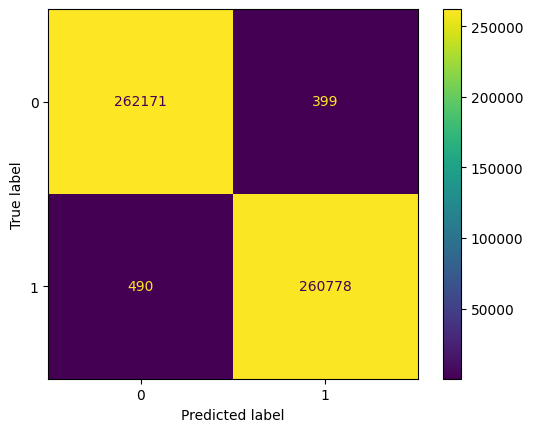

In [34]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=lgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgbest.classes_)
disp.plot()
plt.show()

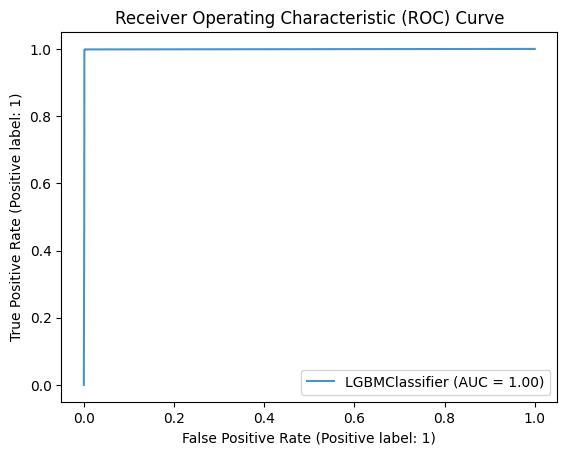

In [35]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(lgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [36]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99848041, 0.99812453]), array([0.99812453, 0.99848041]), array([262570, 261268]))


In [37]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9983024681790282, 0.9983024681790282, None)


In [38]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9983029104417778, 0.9983029104417778, None)


In [39]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9983029104417778, 0.9983020259162787, None)


In [19]:
xgb = XGBClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    xgb.fit(X_train,y_train)

In [20]:
y_pred = xgb.predict(X_test)

In [21]:
accuracy_score(y_test,y_pred)

0.9997002890206514

In [22]:
confusion_matrix(y_test,y_pred)

array([[262416,    154],
       [     3, 261265]])

In [23]:
roc_auc_score(y_test,y_pred)

0.9997010036368089

In [24]:
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBClassifier()
param_grid = {
    'objective' : [None, 'binary:logistic', 'binary:hinge'],
    'max_depth': [None, 20, 30, 50],
    'eta' : [0.0001, 0.001, 0.01, 0.1, 1],
    'tree_method' : ['auto', 'exact']
}

rand2 = RandomizedSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [41]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand2.fit(X_train,y_train)

In [42]:
rand2.best_params_

{'tree_method': 'auto',
 'objective': 'binary:hinge',
 'max_depth': 20,
 'eta': 0.1}

In [43]:
rand2.best_score_

0.9998086236628498

In [44]:
##Training with best parameters
xgbest = XGBClassifier(tree_method='auto',
 objective= 'binary:hinge',
 max_depth=20,
 eta=0.1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    xgbest.fit(X_train,y_train)
y_pred = xgbest.predict(X_test)

In [45]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



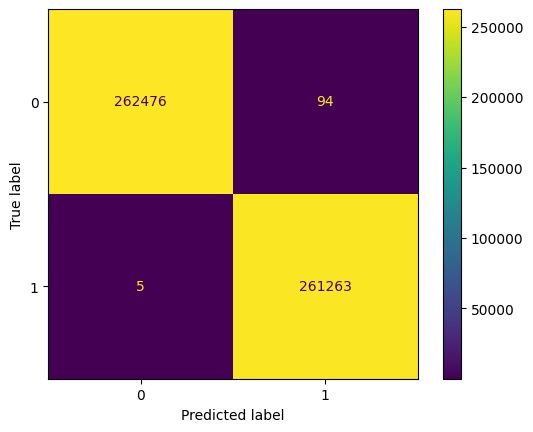

In [46]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=xgbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgbest.classes_)
disp.plot()
plt.show()

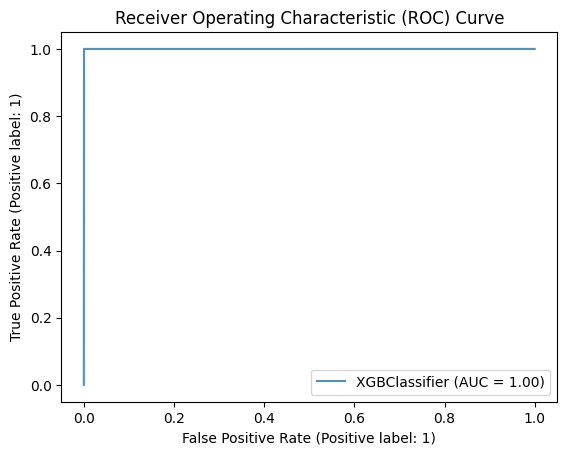

In [47]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(xgbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [48]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.999642  , 0.99998086]), array([0.99998086, 0.999642  ]), array([262570, 261268]))


In [49]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.999811431395545, 0.999811431395545, None)


In [50]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9998110102741687, 0.9998110102741687, None)


In [51]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9998110102741687, 0.9998118525169212, None)


In [25]:
histgb = HistGradientBoostingClassifier()
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    histgb.fit(X_train,y_train)
y_pred = histgb.predict(X_test)

In [26]:
accuracy_score(y_test,y_pred)

0.9996544733295408

In [27]:
confusion_matrix(y_test,y_pred)

array([[262406,    164],
       [    17, 261251]])

In [28]:
roc_auc_score(y_test,y_pred)

0.9996551686833834

In [29]:
param_grid = {
    'max_iter': [100, 200, 300, 500],
    'max_depth': [None, 20, 30, 50],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1]
}

rand4 = RandomizedSearchCV(histgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [30]:
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    rand4.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+----------+
| Package | Client   | Scheduler | Workers  |
+---------+----------+-----------+----------+
| dask    | 2024.7.0 | 2024.5.2  | 2024.7.0 |
+---------+----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/lib/python3.10/site-packages/distributed/client.py:1470: VersionMismatchWarning: Mismatched versions found

+---------+----------+-----------+-

In [31]:
rand4.best_params_

{'max_iter': 300, 'max_depth': 50, 'learning_rate': 0.1}

In [32]:
rand4.best_score_

0.9997236736123615

In [33]:
##Training with best parameters
histbest = HistGradientBoostingClassifier(max_iter=300, max_depth=50, learning_rate=0.1)
with joblib.parallel_backend("dask", scatter=[X_train,y_train]):
    histbest.fit(X_train,y_train)
y_pred = histbest.predict(X_test)

In [34]:
print(classification_report_imbalanced(y_test,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00    262570
          1       1.00      1.00      1.00      1.00      1.00      1.00    261268

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    523838



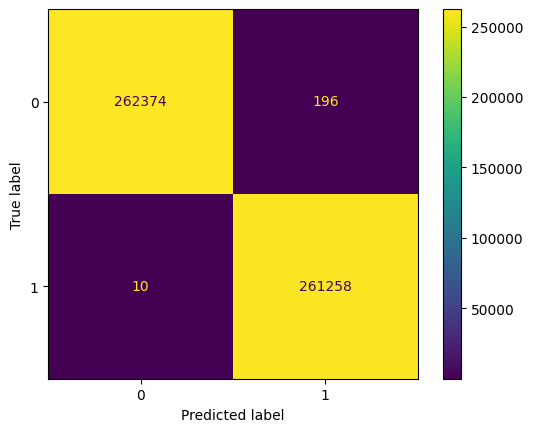

In [35]:
##Plotting Confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=histbest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=histbest.classes_)
disp.plot()
plt.show()

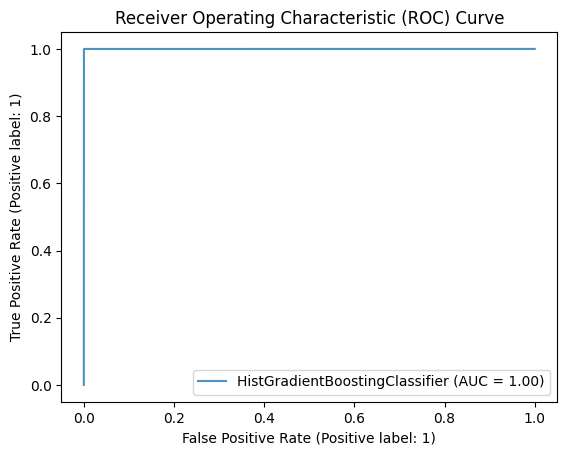

In [36]:
##Plotting ROC Curve

ax = plt.gca()
roc_display = RocCurveDisplay.from_estimator(histbest, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [37]:
print(sensitivity_specificity_support(y_test, y_pred))

(array([0.99925353, 0.99996173]), array([0.99996173, 0.99925353]), array([262570, 261268]))


In [38]:
print(sensitivity_specificity_support(y_test, y_pred, average='macro'))

(0.9996076287582605, 0.9996076287582605, None)


In [39]:
print(sensitivity_specificity_support(y_test, y_pred, average='micro'))

(0.9996067486513006, 0.9996067486513006, None)


In [40]:
print(sensitivity_specificity_support(y_test, y_pred, average='weighted'))

(0.9996067486513006, 0.9996085088652205, None)
